# Saving and Retrieving HITS postage stamps

By: Bryce Kalmbach ([@jbkalmbach](https://github.com/jbkalmbach))

Last updated: 04/28/2020

This notebook shows how we extract postage stamps from 2015 HITS data processed with the LSST stack into warped tracts and patches using the starting pixel coordinates
and the pixel coordinate velocities.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS

%matplotlib inline

In [2]:
from lsst.afw import image as afwImage

## Load in HITS data and KBMOD discoveries in HITS

We stored the HITS data on `pogo4` and will save these stamps to the directory `kbmod/notebooks/hits_postage_stamps`.

In [3]:
hits_image_dir = "/astro/store/pogo4/jbkalmbach/HITS_DATA/tempExp"
hits_data_dir = "hits_data/"

We have a pandas dataframe saved with information on all the visits we processed.

In [4]:
hits_visit_info_df = pd.read_csv(os.path.join(hits_data_dir, "hits_visit_df.csv"), index_col=0)

In [5]:
hits_visit_info_df.head()

visit_num  tract_id filter   field_name     image_mjd  field            ra  \
0     406285        12      r  Blind15A_01  57057.163410      1  09:13:31.152   
1     406287        12      r  Blind15A_01  57057.166057      1  09:13:31.152   
2     406288        13      r  Blind15A_02  57057.167334      2  09:08:53.952   
3     406289        14      r  Blind15A_03  57057.168609      3  09:13:30.840   
4     406290        15      r  Blind15A_04  57057.169878      4  09:08:53.952   

            dec  
0  -06:18:04.68  
1  -06:18:04.68  
2  -04:18:02.81  
3  -02:17:49.30  
4  -00:17:59.06

We also load in a spreadsheet we made with our discoveries. This has the starting pixel and pixel velocity information for each object.

In [6]:
hits_objects = pd.read_csv(os.path.join(hits_data_dir, "hits_found_objects.csv"))

In [7]:
hits_objects.head()

tract  patch_horizontal  patch_vertical    x0    y0       x_vel  \
0      0                 2               4  1622  1500  214.204620   
1      3                 4               4   987  1135  472.435577   
2      5                 5               3  3496  1607  216.298416   
3      7                 4               6  1243  1021  238.136871   
4      7                 4               6  3047  3182  226.968872   

        y_vel  Estimated Distance (AU)  Distance Error  Eccentricity  \
0   81.383980                    67.33           44.44          0.42   
1  223.248917                    21.38            2.77          0.36   
2   94.617867                    43.67           21.99          0.20   
3   76.018631                    48.02           29.09          0.28   
4  100.539658                    37.61           18.18          0.02   

      ...       g_mag    Node  Found in MPChecker?  Notes  Chi Square DOF  \
0     ...       23.68  224.57                   No    NaN        9.73  33   
1     ...       24.14  194.53                   No    NaN       11.89  32   
2     ...       23.74  194.47                   No    NaN        7.78  21   
3     ...       24.19  282.11                   No    NaN       16.57  21   
4     ...       24.24  170.94                   No    NaN       16.51  20   

  Reduced CS      MPC ID  Unnamed: 21  Unnamed: 22  
0   0.294848  2015 DZ248          NaN          NaN  
1   0.371563  2015 DT248          NaN          NaN  
2   0.370476  2015 DT249          NaN          NaN  
3   0.789048  2015 DY248          NaN          NaN  
4   0.825500  2015 DX248          NaN          NaN  

[5 rows x 23 columns]

## Get postage stamps for objects

Using the pixel starting location and velocities as well as the MJD for each visit we can then go in and retrieve the postage stamps we need. The first step is to set the postage stamp size. Stamps that are not a full stamp will be discarded to make saving easier. If running this notebook interactively you can comment out that line.

In [8]:
# Actually half-width since I add this much on each side of the central pixel
stamp_x_width = 80
stamp_y_width = 80

In [9]:
from copy import deepcopy

In [13]:
for obj_num in range(len(hits_objects)):
    obj_data_dict = {}

    obj_mpc_name = hits_objects.iloc[obj_num]["MPC ID"]
    obj_tract = hits_objects.iloc[obj_num]["tract"]
    obj_patch_h = hits_objects.iloc[obj_num]["patch_horizontal"]
    obj_patch_v = hits_objects.iloc[obj_num]["patch_vertical"]
    obj_starting_x = int(hits_objects.iloc[obj_num]["x0"])
    obj_starting_y = int(hits_objects.iloc[obj_num]["y0"])
    obj_vel_x = float(hits_objects.iloc[obj_num]["x_vel"])
    obj_vel_y = float(hits_objects.iloc[obj_num]["y_vel"])

    print(obj_mpc_name)

    # Find the visits for the correct tract
    obj_visits = hits_visit_info_df.query("tract_id == %i" % obj_tract)

    # Starting mjd is the first 'g' visit since that is where our searches start
    obj_start_mjd = obj_visits.query('image_mjd > 57069.9 and image_mjd < 57071 and filter == "g"').iloc[0][
        "image_mjd"
    ]
    sci_stamp_list = []
    sci_mjd_list = []
    sci_filt_list = []
    sci_visit_list = []
    sci_psf_list = []
    mask_stamp_list = []
    var_stamp_list = []
    fluxmag0_list = []
    stamp_center_x = []
    stamp_center_y = []
    stamp_center_ra = []
    stamp_center_dec = []

    first_image_coords = None

    for obj_visit_idx in range(len(obj_visits)):
        obj_visit_id = obj_visits.iloc[obj_visit_idx]["visit_num"]
        obj_visit_filter = obj_visits.iloc[obj_visit_idx]["filter"]
        obj_visit_mjd = obj_visits["image_mjd"].iloc[obj_visit_idx]

        # This is the format for the filename
        obj_visit_path = os.path.join(
            hits_image_dir,
            obj_visit_filter,
            "%i" % obj_tract,
            "%i,%itempExp" % (obj_patch_h, obj_patch_v),
            "v%i-f%s.fits" % (obj_visit_id, obj_visit_filter),
        )

        try:
            hdulist = fits.open(obj_visit_path)
        except FileNotFoundError:
            # print('File Not Found: %s' % obj_visit_path)
            continue

        # Get WCS
        w = WCS(hdulist[1].header)

        sci_img = hdulist[1].data
        mask_img = hdulist[2].data
        var_img = hdulist[3].data

        delta_t = obj_visit_mjd - obj_start_mjd
        obj_stamp_x = np.int(obj_starting_x + delta_t * obj_vel_x)
        obj_stamp_y = np.int(obj_starting_y + delta_t * obj_vel_y)

        coords = w.all_pix2world(np.array([[obj_stamp_x, obj_stamp_y]]), 1)
        # print(coords, delta_t)#, obj_stamp_x, obj_stamp_y, obj_vel_x, obj_vel_y)
        obj_stamp_ra, obj_stamp_dec = coords[0]

        if delta_t >= 0:
            if first_image_coords is None:
                first_image_coords = coords[0]

            # print(coords[0] - first_image_coords)
            # print(obj_vel_x*.26/3600, obj_vel_y*.26/3600)

        sci_stamp = sci_img[
            obj_stamp_y - stamp_y_width : obj_stamp_y + stamp_y_width + 1,
            obj_stamp_x - stamp_x_width : obj_stamp_x + stamp_x_width + 1,
        ]

        ### Comment out the line below if you want to keep all postage stamps
        ### even if they are not the same size as the others because of edge effects
        if np.shape(sci_stamp) != (stamp_y_width * 2 + 1, stamp_x_width * 2 + 1):
            continue
        print(coords, delta_t)
        mask_stamp = mask_img[
            obj_stamp_y - stamp_y_width : obj_stamp_y + stamp_y_width + 1,
            obj_stamp_x - stamp_x_width : obj_stamp_x + stamp_x_width + 1,
        ]
        var_stamp = var_img[
            obj_stamp_y - stamp_y_width : obj_stamp_y + stamp_y_width + 1,
            obj_stamp_x - stamp_x_width : obj_stamp_x + stamp_x_width + 1,
        ]

        obj_exp = afwImage.ExposureF.readFits(obj_visit_path)
        psf_array = obj_exp.getPsf().computeImage().getArray()

        sci_stamp_list.append(sci_stamp)
        sci_mjd_list.append(obj_visit_mjd)
        sci_filt_list.append(obj_visit_filter)
        sci_visit_list.append(obj_visit_id)
        sci_psf_list.append(psf_array)
        mask_stamp_list.append(mask_stamp)
        var_stamp_list.append(var_stamp)
        fluxmag0_list.append(hdulist[0].header["FLUXMAG0"])
        stamp_center_x.append(obj_stamp_x)
        stamp_center_y.append(obj_stamp_y)
        stamp_center_ra.append(obj_stamp_ra)
        stamp_center_dec.append(obj_stamp_dec)
    print(stamp_center_ra, stamp_center_dec)

    obj_data_dict["science_stamps"] = sci_stamp_list
    obj_data_dict["stamp_mjd"] = sci_mjd_list
    obj_data_dict["stamp_filter"] = sci_filt_list
    obj_data_dict["stamp_visits"] = sci_visit_list
    obj_data_dict["psf_stamps"] = sci_psf_list
    obj_data_dict["mask_stamps"] = mask_stamp_list
    obj_data_dict["variance_stamps"] = var_stamp_list
    obj_data_dict["stamp_fluxmag0"] = fluxmag0_list
    obj_data_dict["stamp_center_x"] = stamp_center_x
    obj_data_dict["stamp_center_y"] = stamp_center_y
    obj_data_dict["stamp_center_ra"] = stamp_center_ra
    obj_data_dict["stamp_center_dec"] = stamp_center_dec

    obj_stamp_df = pd.DataFrame(obj_data_dict)
    mpc_obj_year, mpc_obj_id = obj_mpc_name.split(" ")
    obj_stamp_df.to_hdf(
        os.path.join(hits_data_dir, "hits_stamps_160_pix_ra_dec_2.h5"),
        key="stamp_%s_%s" % (mpc_obj_year, mpc_obj_id),
    )

2015 DZ248
[[145.1899165   -4.68030599]] -12.94211789999099
[[144.9339375   -4.58375939]] -0.0675856999878306
[[144.93254492  -4.58320627]] 0.0
[[144.93087397  -4.58265351]] 0.08542880000459263
[[144.92948139  -4.58210038]] 0.15415310001117177
[[144.92855301  -4.58173162]] 0.2011655000023893
[[144.91416354  -4.57629324]] 0.9288142000077642
[[144.91277098  -4.57574008]] 0.996577600009914
[[144.91147134  -4.57527928]] 1.0642389999920852
[[144.91007879  -4.57472611]] 1.1343716000046697
[[144.90868636  -4.57426543]] 1.2033561999996891
[[144.89429714  -4.56882663]] 1.9255484999957844
[[144.89160499  -4.56781259]] 2.0624994000027073
[[144.89021246  -4.56725938]] 2.1311734999981127
[[144.88881994  -4.56670617]] 2.200343399999838
[[144.8744311   -4.56135944]] 2.922920000004524
[[144.85465809  -4.55379907]] 3.920607600004587
[[144.8492741   -4.55186317]] 4.187624999998661
[[144.83479277  -4.54633074]] 4.918191200005822
[[144.83210076  -4.54531647]] 5.05347520000214
[[144.83070842  -4.54485563]]

/nvme/cache/epyc/opt/lsst/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/pandas/core/generic.py:1993: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['science_stamps', 'stamp_filter', 'psf_stamps', 'mask_stamps', 'variance_stamps']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


[[141.49914359  -4.1113554 ]] -0.06784540000080597
[[141.49608377  -4.10987437]] 0.0
[[141.49237489  -4.1081156 ]] 0.08527819999289932
[[141.48940779  -4.10672707]] 0.1539169999959995
[[141.45547246  -4.09071204]] 0.9288139000054798
[[141.4525055   -4.08932337]] 0.9965693999984069
[[141.44953856  -4.0879347 ]] 1.0642327000023215
[[141.44647888  -4.08654597]] 1.1327307999963523
[[141.44341926  -4.08506474]] 1.2031330000027083
[[141.41180369  -4.07015882]] 1.9254904000044917
[[141.40577742  -4.06728862]] 2.0622486999927787
[[141.40281064  -4.06589977]] 2.130993800004944
[[141.39975119  -4.06441838]] 2.2001208999936352
[[141.36813736  -4.04951076]] 2.92293239999708
[[141.32438072  -4.02886035]] 3.9207165999978315
[[141.31279303  -4.02339639]] 4.186319199987338
[[141.28071916  -4.00830019]] 4.918113899999298
[[141.27775291  -4.0068184 ]] 4.9856999999974505
[[141.27478662  -4.00542909]] 5.0532273999997415
[[141.27182033  -4.00403978]] 5.122010799997952
[[141.26876133  -4.0026504 ]] 5.190603

## Retrieving Stamps

Once stamps are saved we can retrieve them from the saved pandas dataframes and we show how to do that here.

In [14]:
# First reopen the dataframe with the list of objects saved.
hits_object_df = pd.read_csv(os.path.join(hits_data_dir, "hits_found_objects.csv"))

In [15]:
hits_object_df.head()

tract  patch_horizontal  patch_vertical    x0    y0       x_vel  \
0      0                 2               4  1622  1500  214.204620   
1      3                 4               4   987  1135  472.435577   
2      5                 5               3  3496  1607  216.298416   
3      7                 4               6  1243  1021  238.136871   
4      7                 4               6  3047  3182  226.968872   

        y_vel  Estimated Distance (AU)  Distance Error  Eccentricity  \
0   81.383980                    67.33           44.44          0.42   
1  223.248917                    21.38            2.77          0.36   
2   94.617867                    43.67           21.99          0.20   
3   76.018631                    48.02           29.09          0.28   
4  100.539658                    37.61           18.18          0.02   

      ...       g_mag    Node  Found in MPChecker?  Notes  Chi Square DOF  \
0     ...       23.68  224.57                   No    NaN        9.73  33   
1     ...       24.14  194.53                   No    NaN       11.89  32   
2     ...       23.74  194.47                   No    NaN        7.78  21   
3     ...       24.19  282.11                   No    NaN       16.57  21   
4     ...       24.24  170.94                   No    NaN       16.51  20   

  Reduced CS      MPC ID  Unnamed: 21  Unnamed: 22  
0   0.294848  2015 DZ248          NaN          NaN  
1   0.371563  2015 DT248          NaN          NaN  
2   0.370476  2015 DT249          NaN          NaN  
3   0.789048  2015 DY248          NaN          NaN  
4   0.825500  2015 DX248          NaN          NaN  

[5 rows x 23 columns]

The filenames are the MPC ID values for each object. We show the dataframe entry for the first object below which includes and how to retrieve the stamps.

Also note magnitude can be calculated by:

```
mag = -2.5*(np.log10(object_flux) - np.log10(fluxmag0))
```

In [16]:
hits_object_df.iloc[0]

tract                               0
patch_horizontal                    2
patch_vertical                      4
x0                               1622
y0                               1500
x_vel                         214.205
y_vel                          81.384
Estimated Distance (AU)         67.33
Distance Error                  44.44
Eccentricity                     0.42
Eccentricity Error               0.41
Inclination                      17.6
Inclination Error                0.24
g_mag                           23.68
Node                           224.57
Found in MPChecker?                No
Notes                             NaN
Chi Square                       9.73
DOF                                33
Reduced CS                   0.294848
MPC ID                     2015 DZ248
Unnamed: 21                       NaN
Unnamed: 22                       NaN
Name: 0, dtype: object

The hdf5 file can be loaded with pandas and the key for the dataframe for each object is the `stamp_(object's mpc year)_(object's mpc id)`.

In [43]:
mpc_name_year, mpc_name_id = hits_object_df["MPC ID"].iloc[-1].split(" ")
stamp_df = pd.read_hdf(
    os.path.join(hits_data_dir, "hits_stamps_160_pix_ra_dec.h5"),
    key="stamp_%s_%s" % (mpc_name_year, mpc_name_id),
)

In [44]:
stamp_df

science_stamps     stamp_mjd  \
0   [[4.636672, -13.220642, -0.71709555, -1.412585...  57070.095981   
1   [[-10.722682, 0.8495673, -0.7582719, 5.4512815...  57070.163427   
2   [[-8.350357, -9.959011, 12.675256, 12.2288, -1...  57070.249361   
3   [[-12.473806, -2.8691726, -2.1452138, 3.913307...  57070.318299   
4   [[6.149808, 1.5132482, 8.250503, 6.8767953, -7...  57070.365211   
5   [[8.449598, -11.899937, -12.775603, 8.8499565,...  57071.092478   
6   [[-1.661271, -6.835757, -1.1425685, 15.409482,...  57071.159978   
7   [[1078.1249, 845.3576, 180.2708, 27.011156, 2....  57071.228174   
8   [[-19.546385, 5.857351, 0.27942082, 4.6095047,...  57071.298510   
9   [[4.563046, -6.0318217, 5.378437, -13.684397, ...  57071.367320   
10  [[-4.286499, 14.638245, 4.8239036, -0.32970718...  57072.089281   
11  [[2.3599012, 5.623147, 8.58799, -5.8125863, -2...  57072.226390   
12  [[8.129571, -1.330134, 11.867825, -6.835511, -...  57072.295407   
13  [[4.296112, 3.4616756, 10.540208, -2.0927572, ...  57072.364319   
14  [[-2.2105591, 12.8911705, 5.4813113, -14.46359...  57073.086693   
15  [[-14.123881, -10.369858, -2.7274277, -2.01540...  57074.083858   
16  [[-7.630624, -5.7314286, 11.949886, -1.1565275...  57074.352676   
17  [[0.012168159, 6.560256, 6.1073904, 2.2932446,...  57075.081735   
18  [[1.0077705, 10.461989, 6.597144, 6.967885, 0....  57075.217503   
19  [[-0.4803423, -2.3486009, -7.850603, 1.5254011...  57075.354907   
20  [[33.63076, -29.825693, 1.5633928, 5.873736, -...  57077.066503   
21  [[-3.1182332, 14.157359, -10.531237, -9.968905...  57077.133811   
22  [[-7.8253956, 0.6297036, -7.9878135, 6.2351427...  57077.195453   

   stamp_filter  stamp_visits  \
0             r        410882   
1             g        410932   
2             g        410988   
3             g        411038   
4             g        411072   
5             g        411272   
6             g        411322   
7             g        411372   
8             g        411423   
9             g        411473   
10            g        411674   
11            g        411775   
12            g        411825   
13            g        411875   
14            g        412077   
15            g        412267   
16            g        412325   
17            g        412521   
18            g        412621   
19            g        412721   
20            r        413602   
21            g        413652   
22            g        413697   

                                           psf_stamps  \
0   [[-1.5605612065996102e-05, -7.920369474575927e...   
1   [[-3.642986698173626e-07, 5.395716291489045e-0...   
2   [[-1.9855214369583163e-05, 4.1071024966837e-05...   
3   [[2.7411767361720993e-06, 1.5594718907255489e-...   
4   [[-3.3076705036328445e-06, 2.007030124399811e-...   
5   [[-2.600407249642612e-07, 6.728869719408516e-0...   
6   [[-3.263143133950192e-06, 2.326293796181121e-0...   
7   [[-2.228951960404427e-06, 1.3846192285756986e-...   
8   [[3.0022934303196924e-05, 0.000103247629848371...   
9   [[1.331147276778292e-05, -7.336357491128763e-0...   
10  [[-3.112418353618649e-05, -9.855210927432593e-...   
11  [[-1.9981396360917627e-06, -3.4382226334174e-0...   
12  [[2.283825964239471e-06, -4.751471154257969e-0...   
13  [[-1.553398047145884e-06, 5.365997829474899e-0...   
14  [[-1.3075264960073602e-05, -9.104140143461909e...   
15  [[1.7878476790265696e-07, 2.4837578289036197e-...   
16  [[-1.8177911355581535e-05, -1.886003923157767e...   
17  [[0.00010191282706776529, 0.000837802933109891...   
18  [[6.690583967992634e-06, -1.7018546787265105e-...   
19  [[0.0008048043211875181, 0.0005188663840470891...   
20  [[-2.933386034767527e-05, -4.184480480798889e-...   
21  [[-1.2160678095092175e-06, -1.84399408986703e-...   
22  [[-7.04362278047604e-08, 9.634078049376976e-06...   

                                          mask_stamps  \
0   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2

Each row is a complete set of stamps for each visit along with the filter, mjd, id and `fluxmag0` term for that exposure.

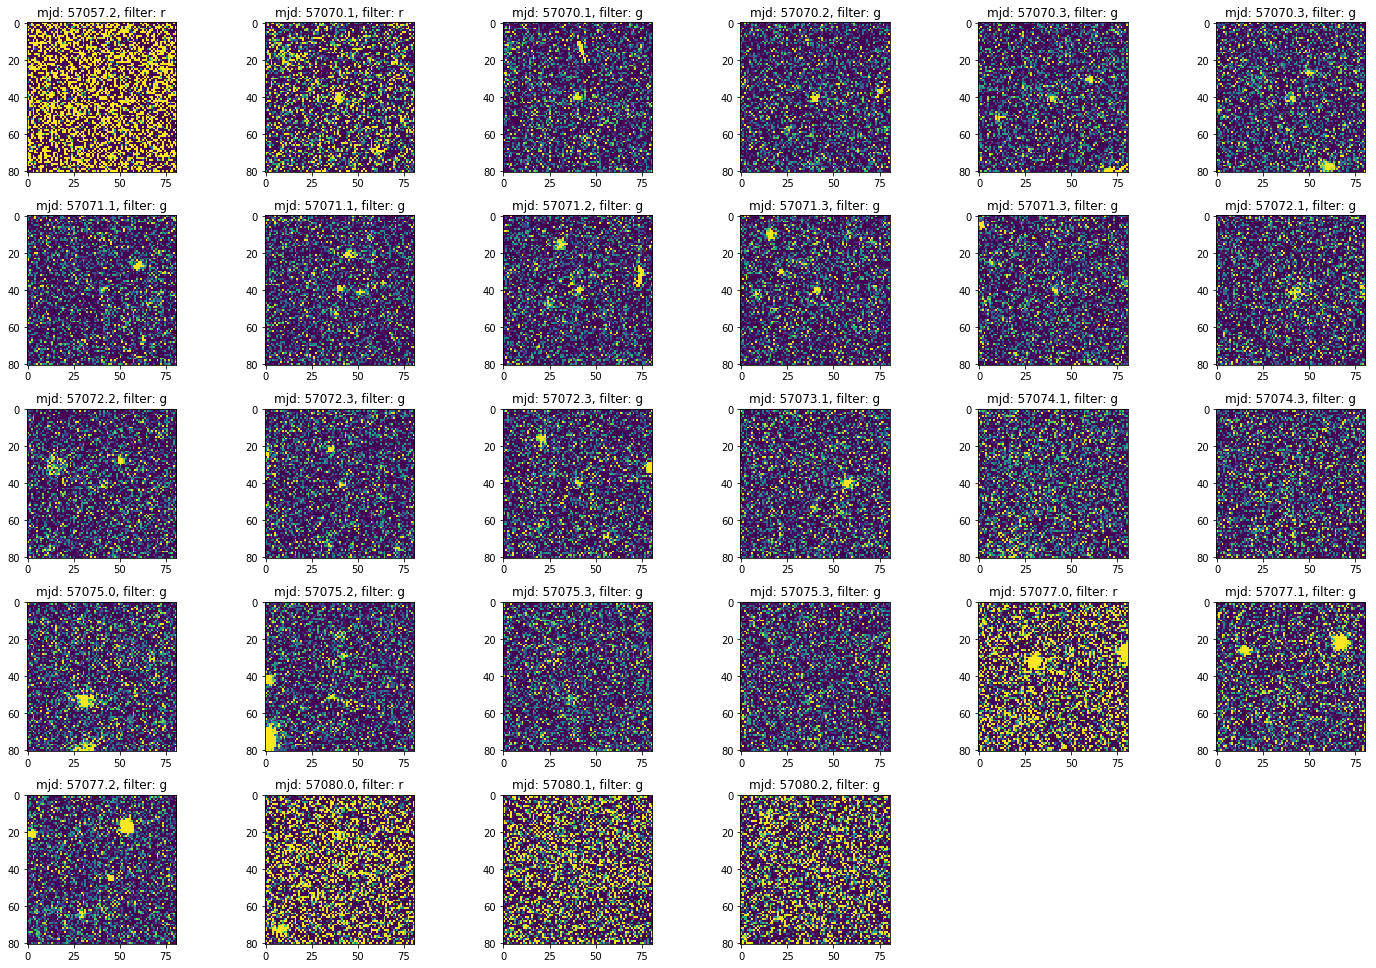

In [15]:
fig = plt.figure(figsize=(20, 16))
for i in range(len(stamp_df)):
    fig.add_subplot(6, 6, i + 1)
    plt.imshow(stamp_df["science_stamps"].iloc[i], vmax=15, vmin=0)
    plt.title("mjd: %.1f, filter: %s" % (stamp_df["stamp_mjd"].iloc[i], stamp_df["stamp_filter"].iloc[i]))
plt.tight_layout()

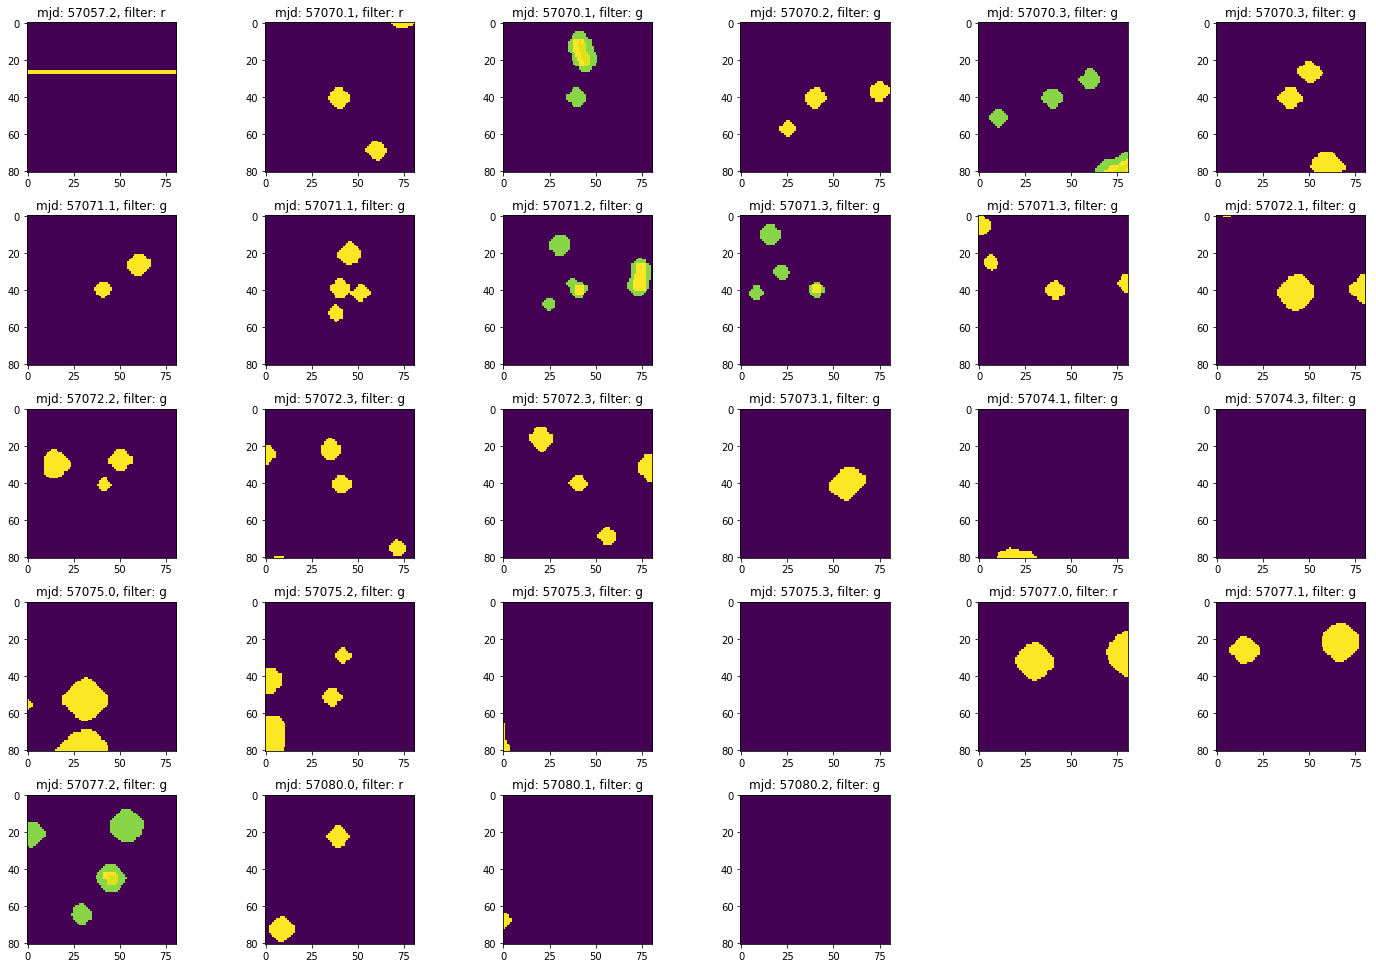

In [16]:
fig = plt.figure(figsize=(20, 16))
for i in range(len(stamp_df)):
    fig.add_subplot(6, 6, i + 1)
    plt.imshow(stamp_df["mask_stamps"].iloc[i])
    plt.title("mjd: %.1f, filter: %s" % (stamp_df["stamp_mjd"].iloc[i], stamp_df["stamp_filter"].iloc[i]))
plt.tight_layout()

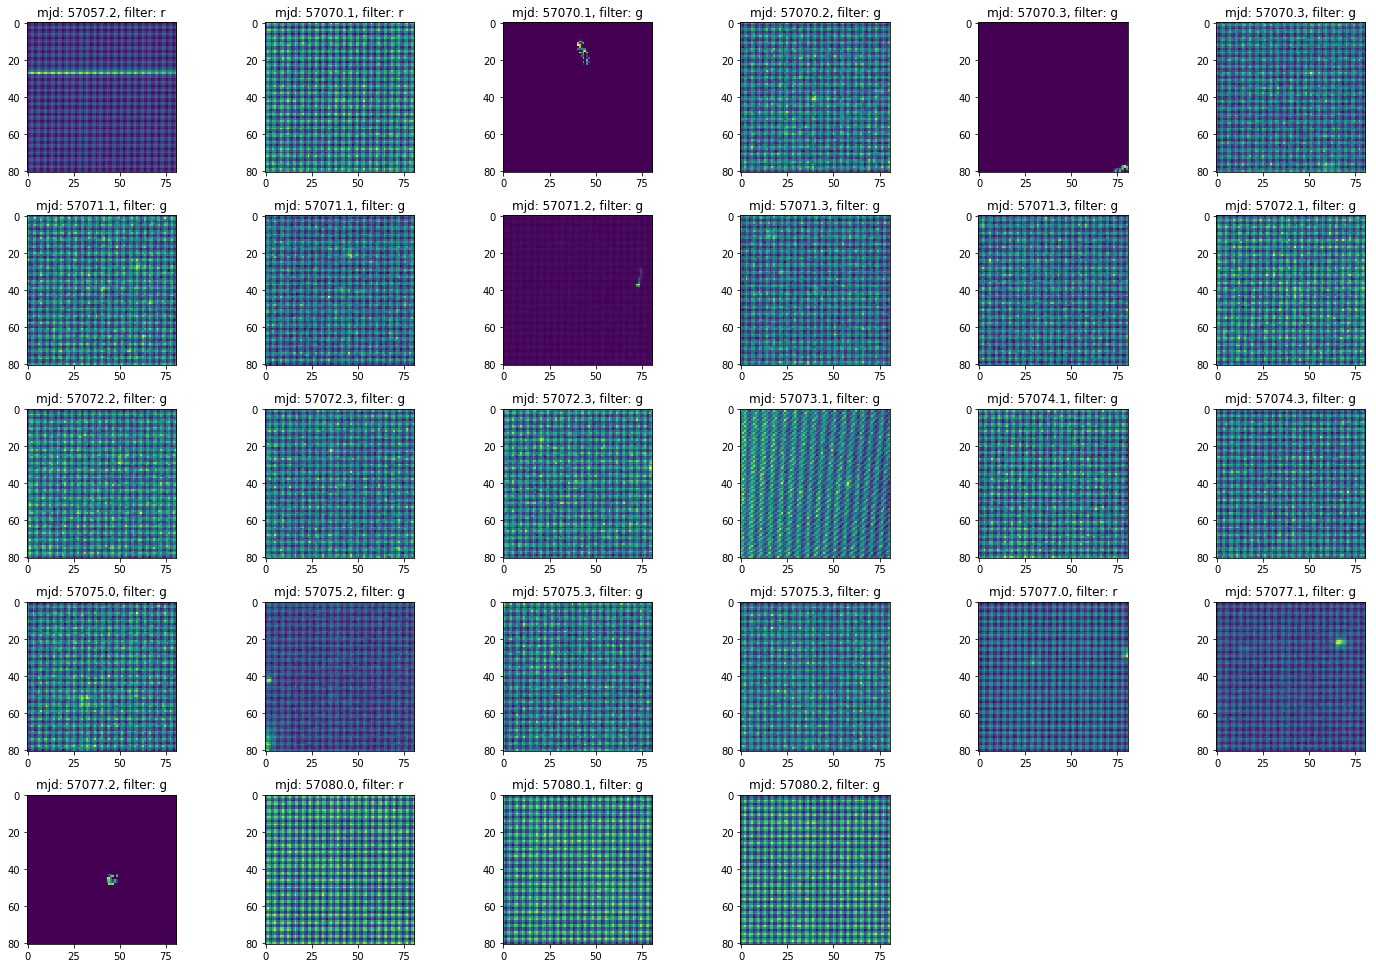

In [17]:
fig = plt.figure(figsize=(20, 16))
for i in range(len(stamp_df)):
    fig.add_subplot(6, 6, i + 1)
    plt.imshow(stamp_df["variance_stamps"].iloc[i])
    plt.title("mjd: %.1f, filter: %s" % (stamp_df["stamp_mjd"].iloc[i], stamp_df["stamp_filter"].iloc[i]))
plt.tight_layout()

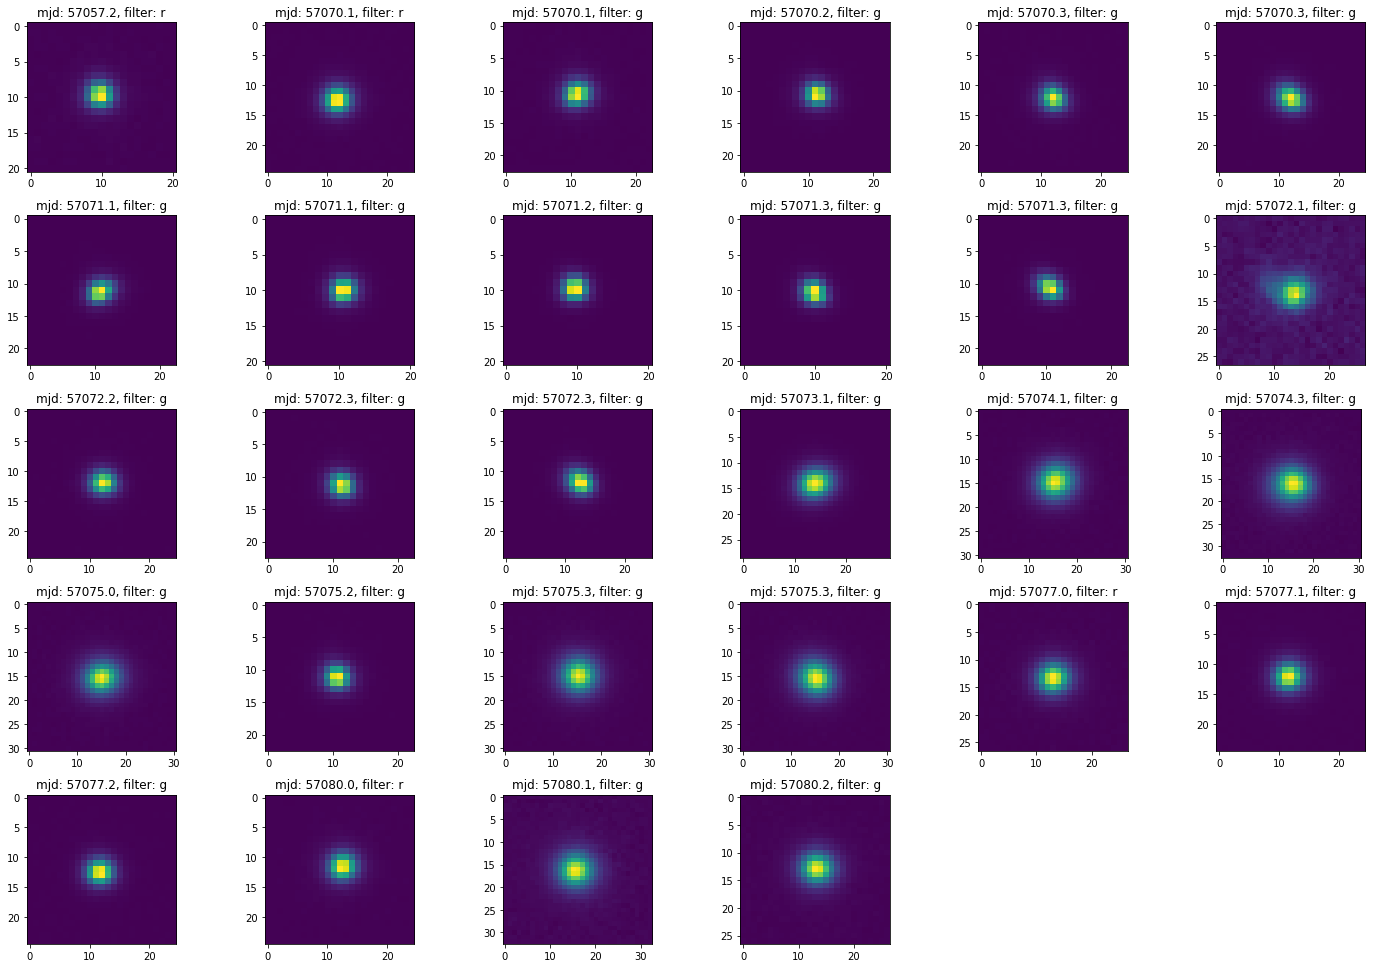

In [18]:
fig = plt.figure(figsize=(20, 16))
for i in range(len(stamp_df)):
    fig.add_subplot(6, 6, i + 1)
    plt.imshow(stamp_df["psf_stamps"].iloc[i])
    plt.title("mjd: %.1f, filter: %s" % (stamp_df["stamp_mjd"].iloc[i], stamp_df["stamp_filter"].iloc[i]))
plt.tight_layout()